In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN import *
from NN_library.train_dual_PINN import *
from NN_library.MN.material_NN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

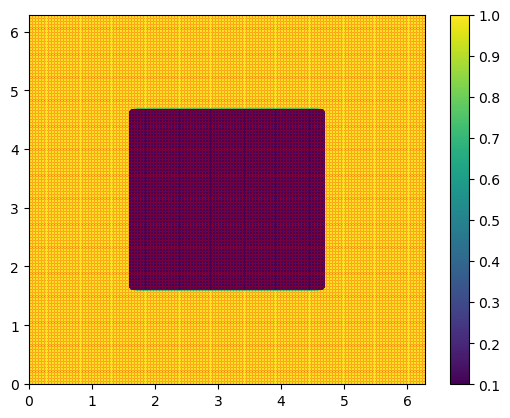

In [4]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

mat_net = Material_NN()
args = {'lr' : 0.001, 'epochs' : 30000, 'dev' : dev, 'name' : f'NN_library/MN/MN_16'}
mat_net = load_network(mat_net, args['name']+'_29999', args).to(dev)

def A_interp(x): 
    a = 0.1 + 0.9*mat_net(x)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    a = 1 / (0.1 + 0.9*mat_net(x))
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = 0.1 + 0.9*mat_net(grid_data).detach().cpu()
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N), vmin=0.1)
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.05, c='r')

# Primal PINN

In [5]:
net_primal = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/MNPINN_primal_{total_params}'}

Number of parameters: 65


In [6]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [6]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  3.55729414e-03, bound:  7.83602595e-01
Epoch: 1 mean train loss:  3.53808631e-03, bound:  7.83599019e-01
Epoch: 2 mean train loss:  3.51896579e-03, bound:  7.83595443e-01
Epoch: 3 mean train loss:  3.49993422e-03, bound:  7.83591807e-01
Epoch: 4 mean train loss:  3.48099112e-03, bound:  7.83588231e-01
Epoch: 5 mean train loss:  3.46213928e-03, bound:  7.83584654e-01
Epoch: 6 mean train loss:  3.44337989e-03, bound:  7.83581078e-01
Epoch: 7 mean train loss:  3.42471362e-03, bound:  7.83577561e-01
Epoch: 8 mean train loss:  3.40614165e-03, bound:  7.83573985e-01
Epoch: 9 mean train loss:  3.38766305e-03, bound:  7.83570409e-01
Epoch: 10 mean train loss:  3.36928247e-03, bound:  7.83566773e-01
Epoch: 11 mean train loss:  3.35099734e-03, bound:  7.83563197e-01
Epoch: 12 mean train loss:  3.33280978e-03, bound:  7.83559620e-01
Epoch: 13 mean train loss:  3.31472117e-03, bound:  7.83556044e-01
Epoch: 14 mean train loss:  3.29673151e-03, bound:  7.83552408e-01
Epoch

In [8]:
np.save(f'NN_library/training_data/square/MNPINN_primal_{total_params}', np.vstack([losses_train, losses_val]))

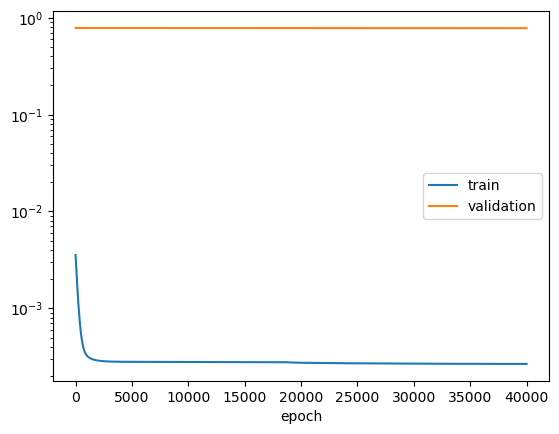

In [7]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [11]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_2, _ = PDE_loss(grid_data, net_primal, A, H1)

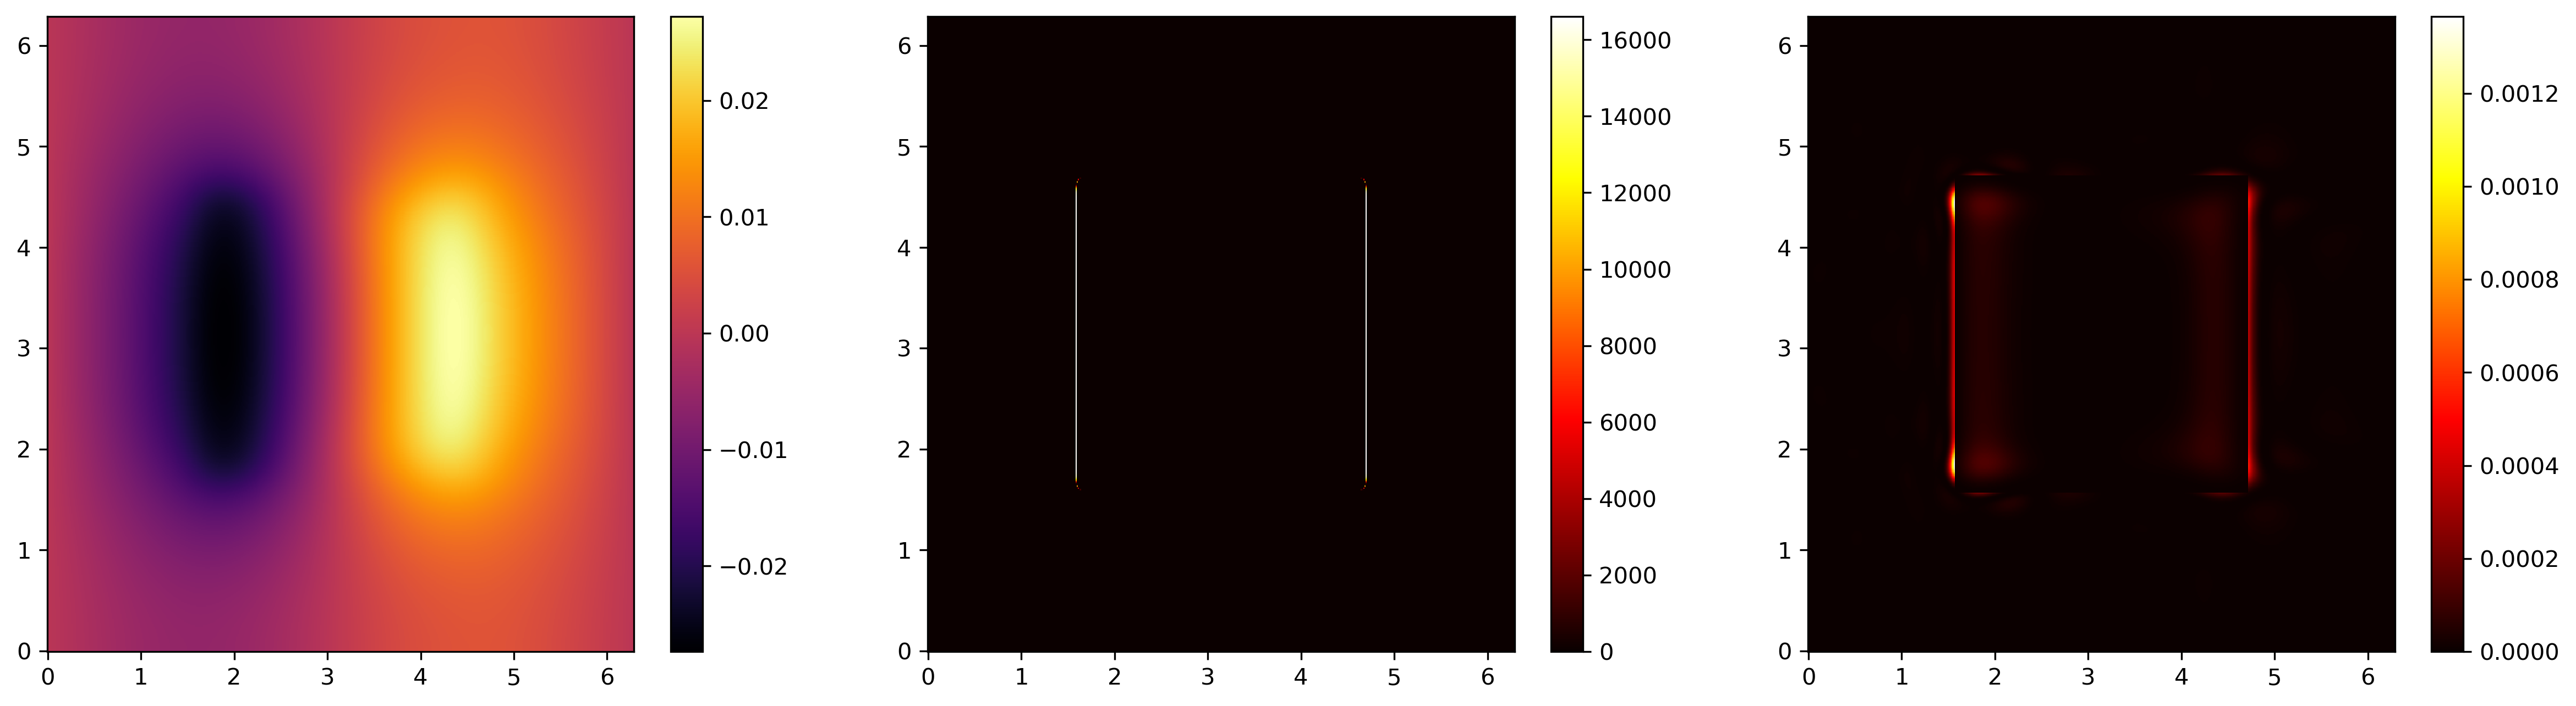

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [8]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach()[0].item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)
bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_MNPINN_{total_params}_{N}.npy', (bound_1, bound_2))

0.7759281396865845
0.7689833134293221


# Dual PINN

In [9]:
net_dual = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/MNPINN_dual_{total_params}'}

Number of parameters: 65


In [10]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [11]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, L)

Epoch: 0 mean train loss:  2.48712063e+00, bound:  3.15604270e-01
Epoch: 1 mean train loss:  2.48698282e+00, bound:  3.15608472e-01
Epoch: 2 mean train loss:  2.48684406e+00, bound:  3.15612793e-01
Epoch: 3 mean train loss:  2.48670578e+00, bound:  3.15617055e-01
Epoch: 4 mean train loss:  2.48656702e+00, bound:  3.15621376e-01
Epoch: 5 mean train loss:  2.48642850e+00, bound:  3.15625668e-01
Epoch: 6 mean train loss:  2.48628950e+00, bound:  3.15629989e-01
Epoch: 7 mean train loss:  2.48615074e+00, bound:  3.15634310e-01
Epoch: 8 mean train loss:  2.48601103e+00, bound:  3.15638661e-01
Epoch: 9 mean train loss:  2.48587203e+00, bound:  3.15643013e-01
Epoch: 10 mean train loss:  2.48573208e+00, bound:  3.15647364e-01
Epoch: 11 mean train loss:  2.48559260e+00, bound:  3.15651745e-01
Epoch: 12 mean train loss:  2.48545218e+00, bound:  3.15656096e-01
Epoch: 13 mean train loss:  2.48531294e+00, bound:  3.15660506e-01
Epoch: 14 mean train loss:  2.48517275e+00, bound:  3.15664917e-01
Epoch

In [13]:
np.save(f'NN_library/training_data/square/MNPINN_dual_{total_params}', np.vstack([losses_train, losses_val]))

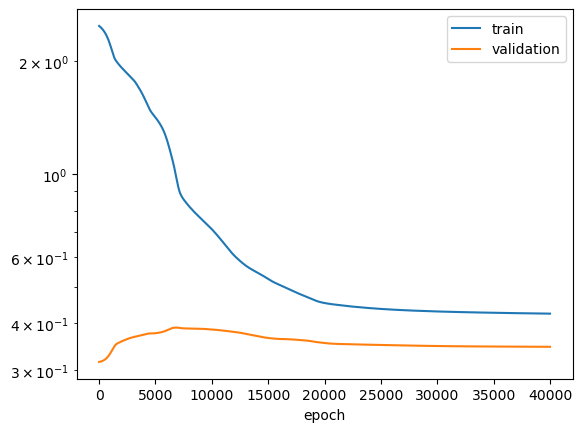

In [12]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [8]:
U2 = net_dual(grid_data).detach().cpu()
error_1, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

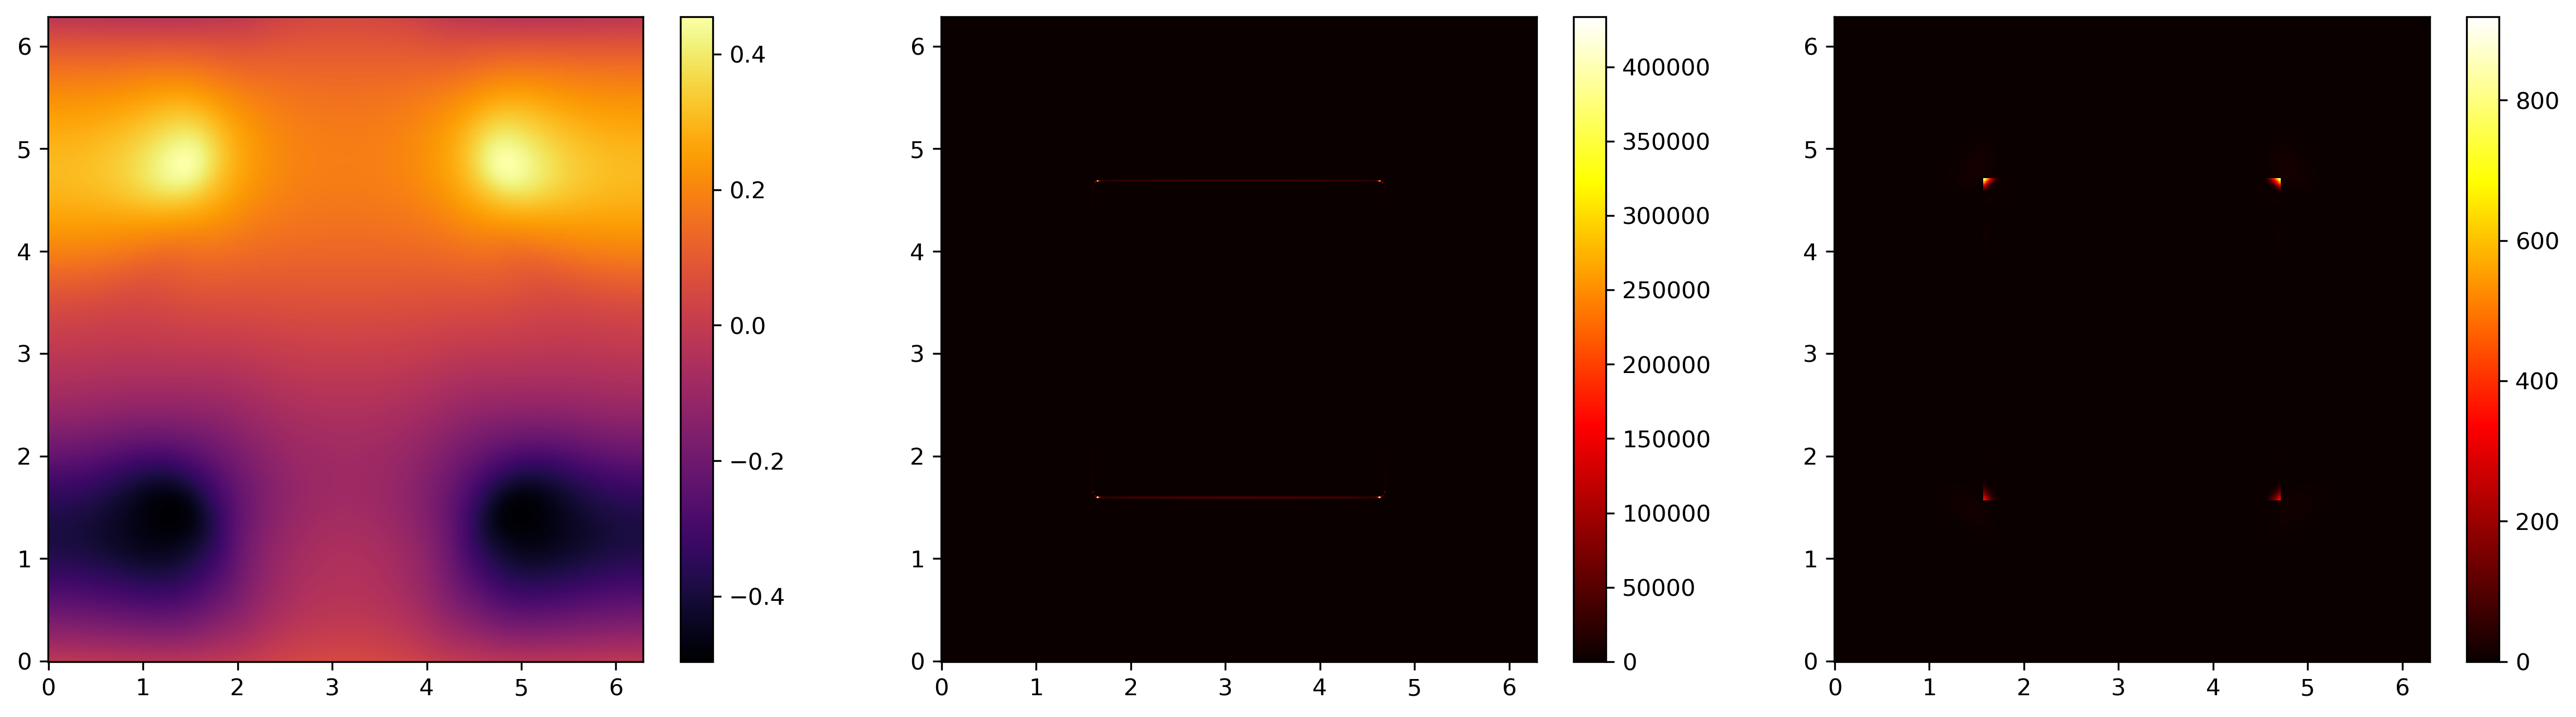

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [16]:
N = 129
data = dataset_grid(N, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, N**2)

In [11]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q2, gH = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach()[0].item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_MNPINN_{total_params}_{N}.npy', (1/bound_1, bound_2))

0.36709939068893715
0.36019856334844486


In [9]:
U1 = net_primal(grid_data).detach().cpu()
error_1_p, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
U2 = net_dual(grid_data).detach().cpu()
error_1_d, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)

Text(0.5, 1.0, 'Dual solution, MNPINN, 65 DoFs')

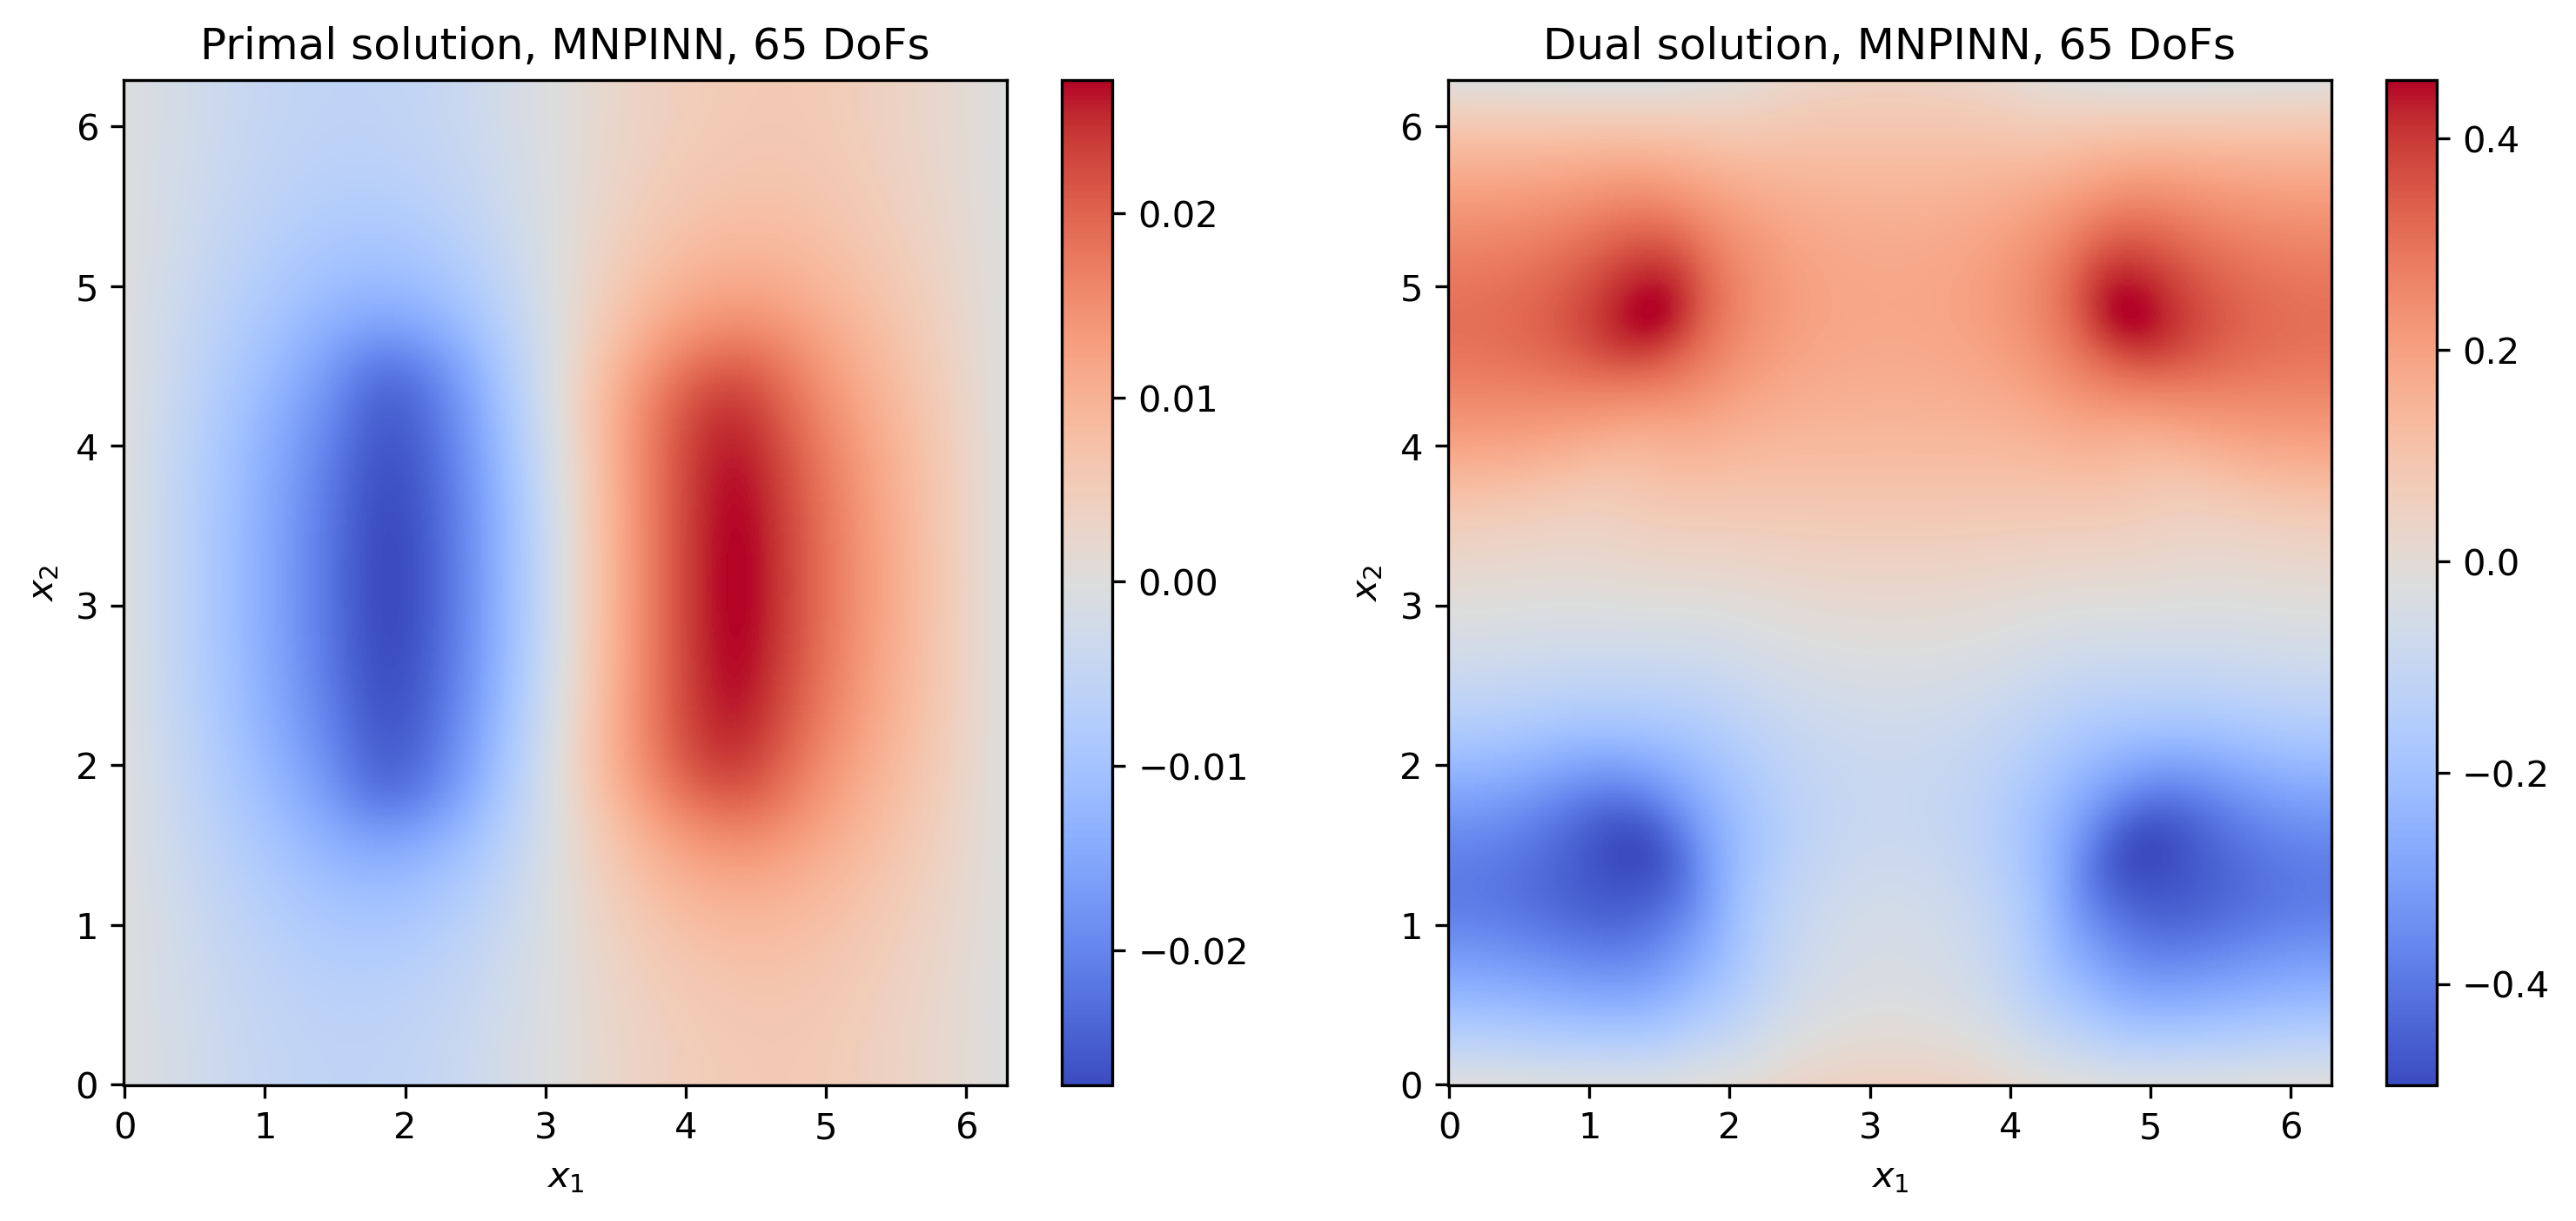

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='coolwarm')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='coolwarm')
fig.colorbar(pos2, ax=axs[1])

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[0].set_title('Primal solution, MNPINN, 65 DoFs')

axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[1].set_title('Dual solution, MNPINN, 65 DoFs')

Text(0.5, 1.0, 'Dual residual, MNPINN, 65 DoFs')

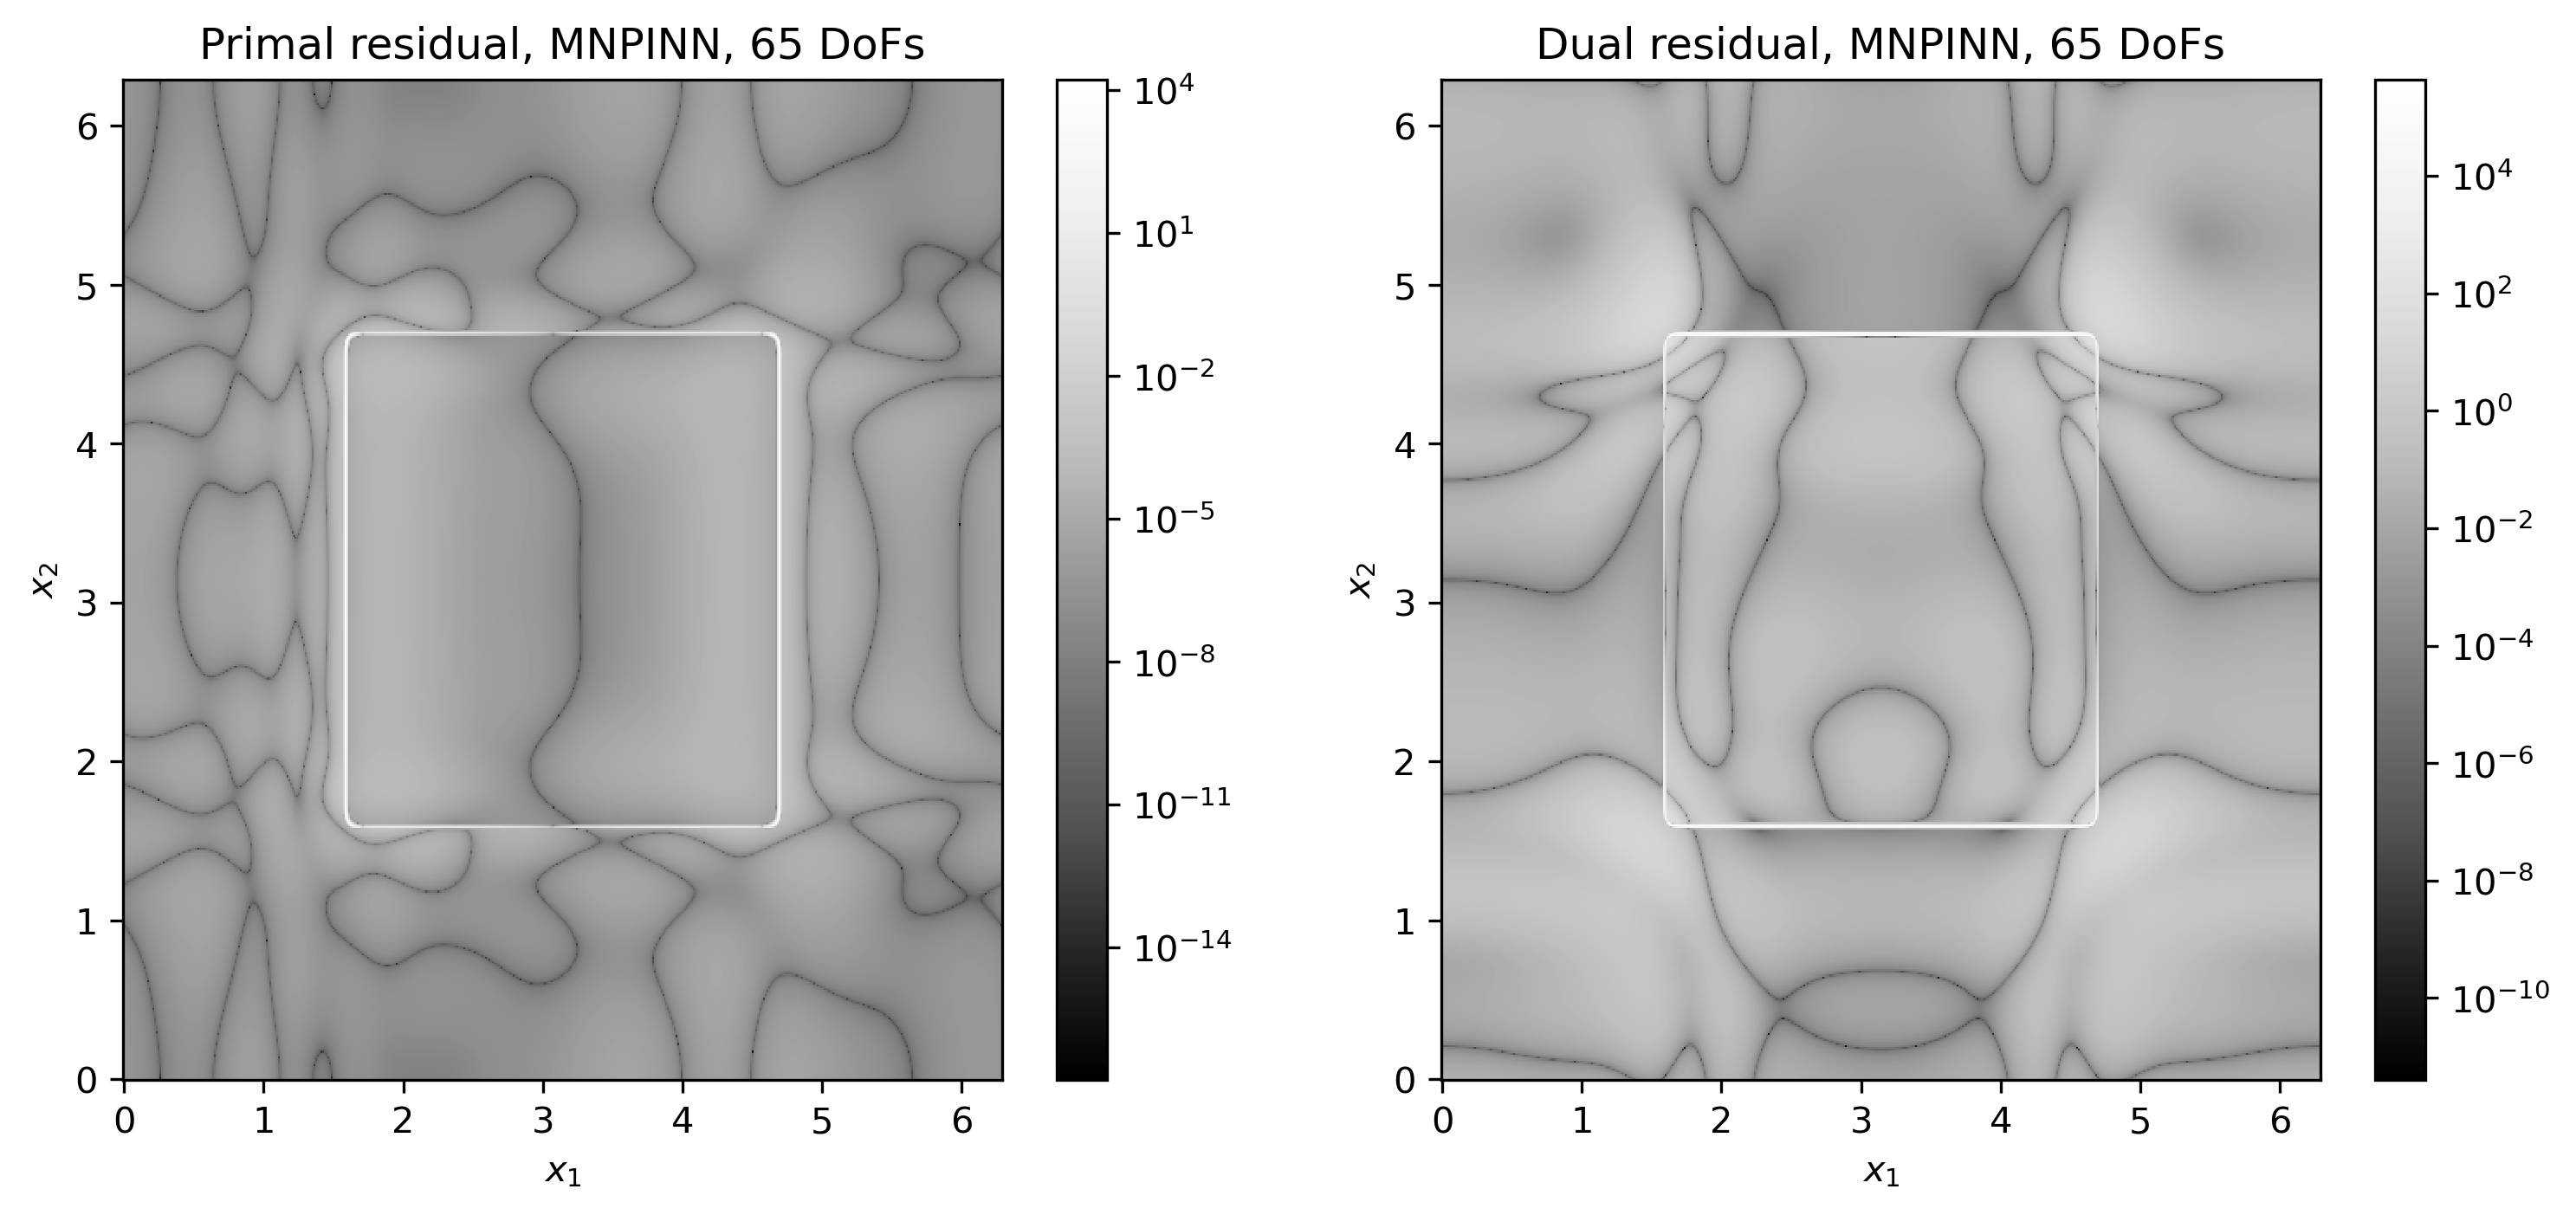

In [11]:
import matplotlib.colors as colors

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], error_1_p.detach().cpu().reshape(N, N), cmap='Greys_r', norm=colors.LogNorm(vmin=error_1_p.min(), vmax=error_1_p.max()))
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1_d.detach().cpu().reshape(N, N), cmap='Greys_r', norm=colors.LogNorm(vmin=error_1_d.min(), vmax=error_1_d.max()))
fig.colorbar(pos2, ax=axs[1])

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[0].set_title('Primal residual, MNPINN, 65 DoFs')

axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[1].set_title('Dual residual, MNPINN, 65 DoFs')